Εργασία 2

Δανάη Πασχαλιά Παπαδοπούλου 1115202000166

Χριστίνα Κοκκινάκη 1115202000083

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import pickle
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from transformers import pipeline
!pip install langdetect
!pip install torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import numpy as np
from gensim.models import Word2Vec
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import random

In [ ]:
# Δημιουργούμε το dataframe για το 2019

keywords=['id', 'comments']

feb2019 = pd.read_csv('/content/drive/MyDrive/data/2019/febrouary/reviews.csv', usecols=keywords)
mar2019 = pd.read_csv('/content/drive/MyDrive/data/2019/march/reviews.csv', usecols=keywords)
apr2019 = pd.read_csv('/content/drive/MyDrive/data/2019/april/reviews.csv', usecols=keywords)

feb2019['month'] = 'feb'
mar2019['month'] = 'mar'
apr2019['month'] = 'apr'

months2019 = []
months2019.append(feb2019)
months2019.append(mar2019)
months2019.append(apr2019)

In [ ]:
# Δημιουργούμε το dataframe για το 2023

keywords=['id', 'comments']

mar2023 = pd.read_csv('/content/drive/MyDrive/data/2023/march/reviews.csv', usecols=keywords)
jun2023 = pd.read_csv('/content/drive/MyDrive/data/2023/june/reviews.csv', usecols=keywords)
sep2023 = pd.read_csv('/content/drive/MyDrive/data/2023/september/reviews.csv', usecols=keywords)

mar2023['month'] = 'mar'
jun2023['month'] = 'jun'
sep2023['month'] = 'sep'

months2023 = []
months2023.append(mar2023)
months2023.append(jun2023)
months2023.append(sep2023)

In [ ]:
reviews2019 = pd.concat(months2019, ignore_index=True)
reviews2023 = pd.concat(months2023, ignore_index=True)

In [ ]:
# Αφαίρεση των comments που υπάρχουν στο datatframe του 2019 από το datatframe του 2023
list2019 = reviews2019['id'].tolist()
mask = reviews2023['id'].isin(list2019)
reviews2023 = reviews2023[~mask]

In [ ]:
# Εκκαθάριση δεδομένων

reviews2019.dropna(subset=['comments'], inplace=True)
reviews2023.dropna(subset=['comments'], inplace=True)

# Αφαίρεση των links
def remove_links(text):
  return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

reviews2019['comments'] = reviews2019['comments'].apply(remove_links)
reviews2023['comments'] = reviews2023['comments'].apply(remove_links)


# Αφαίρεση non utf χαρακτήρων
def remove_non_utf(text):
  return re.sub(r'[^a-zA-Z\s]+', '', text)

reviews2019['comments'] = reviews2019['comments'].apply(remove_non_utf)
reviews2023['comments'] = reviews2023['comments'].apply(remove_non_utf)


# Αφαίρεση των stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)

reviews2019['comments'] = reviews2019['comments'].apply(remove_stopwords)
reviews2023['comments'] = reviews2023['comments'].apply(remove_stopwords)

# Αφαίρεση των γραμμών που έχουν μείνει κενές (empty strings)
reviews2019['comments'].replace('', pd.NA, inplace=True)
reviews2023['comments'].replace('', pd.NA, inplace=True)

reviews2019.dropna(subset=['comments'], inplace=True)
reviews2023.dropna(subset=['comments'], inplace=True)

In [ ]:
# Φιλτράρισμα για negative comments

nltk.download('vader_lexicon')

# Αρχικοποίηση του VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Συνάρτηση για εύρεση αρνητικών σχολίων
def is_negative(comment):
  score = sia.polarity_scores(comment)
  return score['compound'] < 0

negative_comments_2019 = reviews2019[reviews2019['comments'].apply(is_negative)]
negative_comments_2023 = reviews2023[reviews2023['comments'].apply(is_negative)]

In [ ]:
#Αποθήκευση δεδομένων σε αρχεία

negative_comments_2019.to_csv('all_negative_comments_2019.csv', index=False)
negative_comments_2023.to_csv('all_negative_comments_2023.csv', index=False)

In [ ]:
#Λήψη δεδομένων από αρχεία

negative_comments_2019 = pd.read_csv('/content/drive/MyDrive/all_negative_comments_2019.csv')
negative_comments_2023 = pd.read_csv('/content/drive/MyDrive/all_negative_comments_2023.csv')

In [ ]:
# Αφαίρεση των αρνητικών σχολίων από το reviews2019 - reviews2023

merged = pd.merge(reviews2019, negative_comments_2019, on=['id', 'comments' , 'month'], how='inner')
positive_neutral_comments_2019 = reviews2019[~reviews2019.set_index(['id', 'comments' , 'month']).index.isin(merged.set_index(['id', 'comments' ,'month']).index)]

merged = pd.merge(reviews2023, negative_comments_2023, on=['id', 'comments' , 'month'], how='inner')
positive_neutral_comments_2023 = reviews2023[~reviews2023.set_index(['id', 'comments' , 'month']).index.isin(merged.set_index(['id', 'comments' ,'month']).index)]


In [ ]:
# Kρατάμε ξεχωριστά dataframes που περιέχουν τα δεδομένα του positive_neutral_comments_2019 και sampled_negative_comments_2019 για κάθε μήνα ξεχωριστά

feb19_pos_neu = positive_neutral_comments_2019[positive_neutral_comments_2019['month'] == 'feb'].reset_index(drop=True)
mar19_pos_neu = positive_neutral_comments_2019[positive_neutral_comments_2019['month'] == 'mar'].reset_index(drop=True)
apr19_pos_neu = positive_neutral_comments_2019[positive_neutral_comments_2019['month'] == 'apr'].reset_index(drop=True)

feb19_neg = negative_comments_2019[negative_comments_2019['month'] == 'feb'].reset_index(drop=True)
mar19_neg = negative_comments_2019[negative_comments_2019['month'] == 'mar'].reset_index(drop=True)
apr19_neg = negative_comments_2019[negative_comments_2019['month'] == 'apr'].reset_index(drop=True)

# Kρατάμε ξεχωριστά dataframes που περιέχουν τα δεδομένα του positive_neutral_comments_2023 και negative_comments_2023 για κάθε μήνα ξεχωριστά

mar23_pos_neu = positive_neutral_comments_2023[positive_neutral_comments_2023['month'] == 'mar'].reset_index(drop=True)
jun23_pos_neu = positive_neutral_comments_2023[positive_neutral_comments_2023['month'] == 'jun'].reset_index(drop=True)
sep23_pos_neu = positive_neutral_comments_2023[positive_neutral_comments_2023['month'] == 'sep'].reset_index(drop=True)

mar23_neg = negative_comments_2023[negative_comments_2023['month'] == 'mar'].reset_index(drop=True)
jun23_neg = negative_comments_2023[negative_comments_2023['month'] == 'jun'].reset_index(drop=True)
sep23_neg = negative_comments_2023[negative_comments_2023['month'] == 'sep'].reset_index(drop=True)


In [ ]:
# Κρατάμε 1000 τυχαία μη αρνητικά και 700 αρνητικα reviews από κάθε μήνα

#2019
feb19_pos_neu = feb19_pos_neu.sample(n=3000, random_state=42)
mar19_pos_neu = mar19_pos_neu.sample(n=3000, random_state=42)
apr19_pos_neu = apr19_pos_neu.sample(n=3000, random_state=42)

feb19_neg = feb19_neg.sample(n=3000, random_state=42)
mar19_neg = mar19_neg.sample(n=3000, random_state=42)
apr19_neg = apr19_neg.sample(n=3000, random_state=42)

#2023
mar23_pos_neu = mar23_pos_neu.sample(n=3000, random_state=42)
jun23_pos_neu = jun23_pos_neu.sample(n=3000, random_state=42)
sep23_pos_neu = sep23_pos_neu.sample(n=3000, random_state=42)

mar23_neg = mar23_neg.sample(n=3000, random_state=42)
jun23_neg = jun23_neg.sample(n=3000, random_state=42)
sep23_neg = sep23_neg.sample(n=3000, random_state=42)

In [ ]:
# Κρατάμε μόνο τα αγγλικά reviews

from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0
def is_english(text):
  try:
    return detect(text) == 'en'
  except:
    return False

#2019
feb19_pos_neu = feb19_pos_neu[feb19_pos_neu['comments'].apply(is_english)]
mar19_pos_neu = mar19_pos_neu[mar19_pos_neu['comments'].apply(is_english)]
apr19_pos_neu = apr19_pos_neu[apr19_pos_neu['comments'].apply(is_english)]

feb19_neg = feb19_neg[feb19_neg['comments'].apply(is_english)]
mar19_neg = mar19_neg[mar19_neg['comments'].apply(is_english)]
apr19_neg = apr19_neg[apr19_neg['comments'].apply(is_english)]

#2023
mar23_pos_neu = mar23_pos_neu[mar23_pos_neu['comments'].apply(is_english)]
jun23_pos_neu = jun23_pos_neu[jun23_pos_neu['comments'].apply(is_english)]
sep23_pos_neu = sep23_pos_neu[sep23_pos_neu['comments'].apply(is_english)]

mar23_neg = mar23_neg[mar23_neg['comments'].apply(is_english)]
jun23_neg = jun23_neg[jun23_neg['comments'].apply(is_english)]
sep23_neg = sep23_neg[sep23_neg['comments'].apply(is_english)]

In [ ]:
# Από τα αγγλικά reviews κρατάμε για κάθε μήνα 150 negative και άλλα 350 (positive και neutral) reviews

#2019
feb19_pos_neu = feb19_pos_neu.sample(n=350, random_state=42)
mar19_pos_neu = mar19_pos_neu.sample(n=350, random_state=42)
apr19_pos_neu = apr19_pos_neu.sample(n=350, random_state=42)

feb19_neg = feb19_neg.sample(n=150, random_state=42)
mar19_neg = mar19_neg.sample(n=150, random_state=42)
apr19_neg = apr19_neg.sample(n=150, random_state=42)

#2023
mar23_pos_neu = mar23_pos_neu.sample(n=350, random_state=42)
jun23_pos_neu = jun23_pos_neu.sample(n=350, random_state=42)
sep23_pos_neu = sep23_pos_neu.sample(n=350, random_state=42)

mar23_neg = mar23_neg.sample(n=150, random_state=42)
jun23_neg = jun23_neg.sample(n=150, random_state=42)
sep23_neg = sep23_neg.sample(n=150, random_state=42)

In [ ]:
# Δημιουργούμε καινούργια dataframes με τα δεδομένα που επιλέχθηκαν

months2019 = []
months2019.append(feb19_pos_neu)
months2019.append(mar19_pos_neu)
months2019.append(apr19_pos_neu)
months2019.append(feb19_neg)
months2019.append(mar19_neg)
months2019.append(apr19_neg)

months2023 = []
months2023.append(mar23_pos_neu)
months2023.append(jun23_pos_neu)
months2023.append(sep23_pos_neu)
months2023.append(mar23_neg)
months2023.append(jun23_neg)
months2023.append(sep23_neg)

df_2019 = pd.concat(months2019, ignore_index=True)
df_2023 = pd.concat(months2023, ignore_index=True)

In [ ]:
#Αποθήκευση δεδομένων σε αρχεία

df_2019.to_csv('filtered_comments_2019.csv', index=False)
df_2023.to_csv('filtered_comments_2023.csv', index=False)

In [ ]:
#Λήψη δεδομένων από αρχεία

df_2019 = pd.read_csv('/content/drive/MyDrive/filtered_comments_2019.csv')
df_2023 = pd.read_csv('/content/drive/MyDrive/filtered_comments_2023.csv')

In [ ]:
# Ερώτημα 1
from transformers import pipeline, AutoTokenizer

classifier = pipeline("text-classification", model="j-hartmann/sentiment-roberta-large-english-3-classes", top_k=None)
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/sentiment-roberta-large-english-3-classes")

# 2019

sentiment_labels = []

# Αποθηκεύουμε το sentiment από κάθε comment σε μία λίστα
for comment in df_2019['comments']:
  sentiment = classifier(comment)
  sentiment_labels.append(sentiment[0][0]['label'])

# Προσθέτουμε τα δεδομένα για το sentiment ως στήλη στο dataframe
df_2019['sentiment'] = sentiment_labels


# 2023

# Το συγκεκριμένο σχόλιο προκαλούσε πρόβλημα στην εύρεση του sentiment λόγω του μεγέθους του, οπότε κρατήσαμε ένα μικρότερο κομμάτι του.
df_2023.loc[df_2023['id'] == 504198742656297692, 'comments'] = "TRUST DONT BOOK PLACE NEVER JUDGE BOOK COVERbrIt took two days book place host would answer questions late vaguely manner brBecause past reviews internet waiting YES answer internet fixed two days finally answered YES works brI booked check pm since mention twice check pm didnt problem never even asked check early unit units identical told couple staying met accidentally came apartment Ill mention happen belowbrHis property nice beautiful building studio apartment clean well crumbs counter hairstains bedding bathroom try log onto internet internet wasnt working texted Dimitri messing around router putting different internet names passcodes literally wasted one half hour messing around internet success told figure tomorrow calling wifi provider notice toilet seat missing addressed issue told special order waiting arrive suggested bring cheap toilet seat place use toilet especially cause serious back problem ignored suggestion didnt realize elevator leads room doesnt lock behind enter couple walked room accident thinking theres shock straw broke camels back touched mattress notice soft ran hands across broken springs sides bed Pfff said thats called Dimitri told stay important things broken"

sentiment_labels = []

# Αποθηκεύουμε το sentiment από κάθε comment σε μία λίστα
for comment in df_2023['comments']:
  inputs = tokenizer(comment, truncation=True, max_length=512, return_tensors='pt')
  sentiment = classifier(comment)
  sentiment_labels.append(sentiment[0][0]['label'])

# Προσθέτουμε τα δεδομένα για το sentiment ως στήλη στο dataframe
df_2023['sentiment'] = sentiment_labels


# Αποθηκεύουμε τα dataframes ως αρχεία
df_2019.to_csv('sentiments_2019.csv', index=False)
df_2023.to_csv('sentiments_2023.csv', index=False)

In [85]:
#Λήψη δεδομένων από αρχεία
sentiments_2019 = pd.read_csv('/content/drive/MyDrive/sentiments_2019.csv')
sentiments_2023 = pd.read_csv('/content/drive/MyDrive/sentiments_2023.csv')

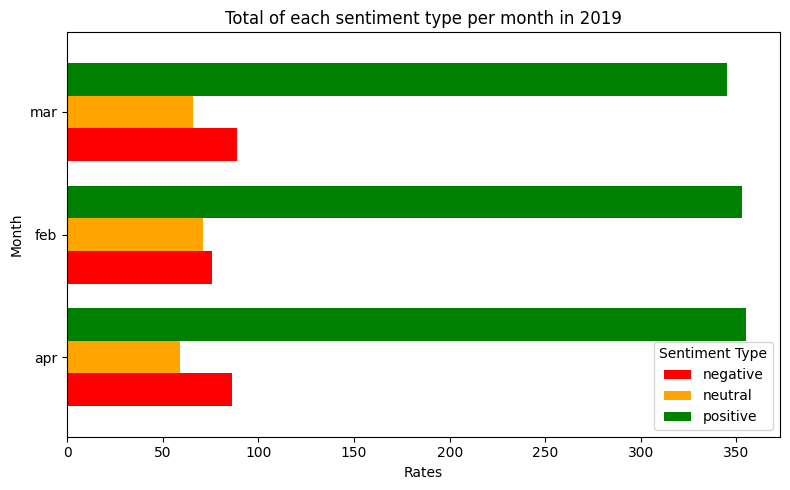

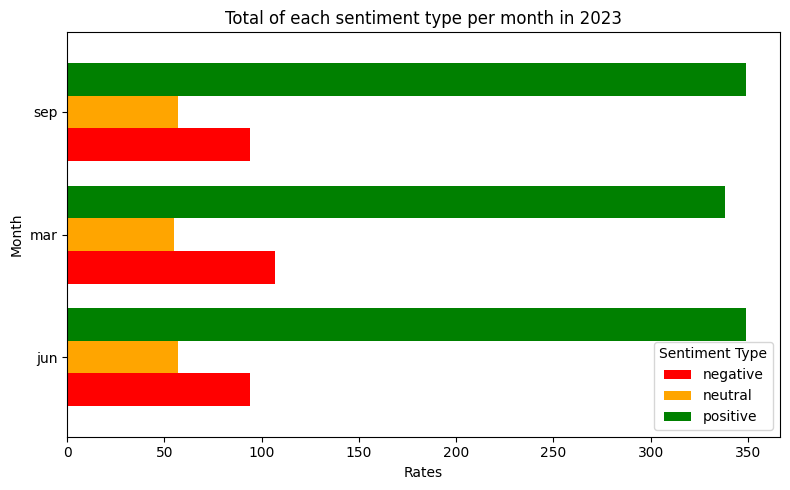

In [ ]:
# Δημιουργούμε τα ιστογράμματα

#2019
sentiments2019 = sentiments_2019.groupby(['month','sentiment']).size().unstack()
colors = {
  'positive': 'green',
  'neutral': 'orange',
  'negative': 'red'
}

color_list = [colors[col] for col in sentiments2019.columns]
ax = sentiments2019.plot(kind='barh', figsize=(8, 5), width=0.8, color=color_list)

plt.title('Total of each sentiment type per month in 2019')
plt.ylabel('Month')
plt.xlabel('Rates')
plt.xticks(rotation=0)

plt.legend(title='Sentiment Type')
plt.tight_layout()
plt.show()

#2023
sentiments2023 = sentiments_2023.groupby(['month','sentiment']).size().unstack()

colors = {
  'positive': 'green',
  'neutral': 'orange',
  'negative': 'red'
}

color_list = [colors[col] for col in sentiments2019.columns]
ax = sentiments2023.plot(kind='barh', figsize=(8, 5), width=0.8, color=color_list)

plt.title('Total of each sentiment type per month in 2023')
plt.ylabel('Month')
plt.xlabel('Rates')
plt.xticks(rotation=0)

plt.legend(title='Sentiment Type')
plt.tight_layout()
plt.show()

In [86]:
# Ερώτημα 2
# Διαχωρισμός δεδομένων train (80%) και test (20%), και κατασκεύη νέων αρχείων

# 2019
# Διαχωρισμός δεδομένων
train_df_2019, test_df_2019 = train_test_split(sentiments_2019, test_size=0.2, random_state=42)

# Αποθήκευση των δεδομένων σε αρχεία TSV
train_df_2019.to_csv('train2019.tsv', sep='\t', index=False)
test_df_2019.to_csv('test2019.tsv', sep='\t', index=False)


# 2023
# Διαχωρισμός δεδομένων
train_df_2023, test_df_2023 = train_test_split(sentiments_2023, test_size=0.2, random_state=42)

# Αποθήκευση των δεδομένων σε αρχεία TSV
train_df_2023.to_csv('train2023.tsv', sep='\t', index=False)
test_df_2023.to_csv('test2023.tsv', sep='\t', index=False)


In [87]:
# Εκπαίδευση του TF-IDF μετασχηματιστή

# Δημιουργούμε to TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# 2019

# Ανάλυση και υπολογισμός των δεδομένων για training, και μετατροπή σε πίνακα
train2019_tfidf = tfidf_vectorizer.fit_transform(train_df_2019['comments'])
# Μετατροπή των δεδομένων για testing σε πίνακα
test2019_tfidf = tfidf_vectorizer.transform(test_df_2019['comments'])

# Αποθήκευση των δεδομένων σε αρχεία pickle
with open('train2019_tfidf.pkl', 'wb') as file:
  pickle.dump(train2019_tfidf, file)

with open('test2019_tfidf.pkl', 'wb') as file:
  pickle.dump(test2019_tfidf, file)


# 2023

# Ανάλυση και υπολογισμός των δεδομένων για training, και μετατροπή σε πίνακα
train2023_tfidf = tfidf_vectorizer.fit_transform(train_df_2023['comments'])
# Μετατροπή των δεδομένων για testing σε πίνακα
test2023_tfidf = tfidf_vectorizer.transform(test_df_2023['comments'])

# Αποθήκευση των δεδομένων σε αρχεία pickle
with open('train2023_tfidf.pkl', 'wb') as file:
  pickle.dump(train2023_tfidf, file)

with open('test2023_tfidf.pkl', 'wb') as file:
  pickle.dump(test2023_tfidf, file)


In [ ]:
# Εκπαίδευση του μοντέλου Word2Vec

# Συνάρτηση για την εξαγωγή του Word2Vec embedding από ένα σχόλιο χρησιμοποιώντας τα μοντέλα που θα δημιουργηθούν
def w2v_embedding(comment, model, vector_size=100):
  words = comment.split() # Χωρίζουμε το comment σε λέξεις/tokens
  embedding = np.zeros(vector_size) # Αρχικοποιούμε τον πίνακα για τα embeddings
  count = 0 # Κρατάμε πόσες λέξεις στο comment έχουν embeddings

  for word in words:
    if word in model.wv: # Αν η τρέχουσα λέξη υπάρχει στο λεξιλόγιο του μοντέλου, κρατάμε το embedding της
      embedding += model.wv[word]
      count += 1

  # Υπολογίζουμε το μέσο embedding του τρέχοντος comment
  if count > 0:
    embedding /= count
  return embedding


#2019

# Χωρίζουμε τα comments σε λέξεις/tokens
train2019_comments = train_df_2019['comments'].apply(lambda x: x.split())
test2019_comments = test_df_2019['comments'].apply(lambda x: x.split())

# "Εκπαιδεύουμε" το μοντέλο
model_w2v_2019 = Word2Vec(sentences=train2019_comments, vector_size=100, window=5, min_count=1, workers=2)

# "extra" εκπαίδευση του μοντέλου για βελτίωση των αποτελεσμάτων
model_w2v_2019.train(train2019_comments, total_examples=len(train2019_comments), epochs=20)

# Αποθήκευση του μοντέλου σε αρχείο pickle
with open('model_w2v_2019.pkl', 'wb') as file:
  pickle.dump(model_w2v_2019, file)

# Δημιουργούμε πίνακες με τα Word2Vec embeddings για κάθε σχόλιο του train dataframe και test dataframe
train2019_w2v = np.array([w2v_embedding(comment, model_w2v_2019) for comment in train_df_2019['comments']])
test2019_w2v = np.array([w2v_embedding(comment, model_w2v_2019) for comment in test_df_2019['comments']])

# Αποθήκευση των χαρακτηριστικών σε αρχεία pickle
with open('train2019_w2v.pkl', 'wb') as file:
  pickle.dump(train2019_w2v, file)

with open('test2019_w2v.pkl', 'wb') as file:
  pickle.dump(test2019_w2v, file)


#2023

# Χωρίζουμε τα comments σε λέξεις/tokens
train2023_comments = train_df_2023['comments'].apply(lambda x: x.split())
test2023_comments = test_df_2023['comments'].apply(lambda x: x.split())

# "Εκπαιδεύουμε" το μοντέλο
model_w2v_2023 = Word2Vec(sentences=train2023_comments, vector_size=100, window=5, min_count=1, workers=4)

# "extra" εκπαίδευση του μοντέλου για βελτίωση των αποτελεσμάτων
model_w2v_2023.train(train2023_comments, total_examples=len(train2023_comments), epochs=20)

# Αποθήκευση του μοντέλου σε αρχείο pickle
with open('model_w2v_2023.pkl', 'wb') as file:
  pickle.dump(model_w2v_2023, file)

# Δημιουργία έναν πίνακα με τα Word2Vec embeddings για κάθε σχόλιο του train και test dataframe
train2023_w2v = np.array([w2v_embedding(comment, model_w2v_2023) for comment in train_df_2023['comments']])
test2023_w2v = np.array([w2v_embedding(comment, model_w2v_2023) for comment in test_df_2023['comments']])

# Αποθήκευση των χαρακτηριστικών σε αρχεία pickle
with open('train2023_w2v.pkl', 'wb') as file:
  pickle.dump(train2023_w2v, file)

with open('test2023_w2v.pkl', 'wb') as file:
  pickle.dump(test2023_w2v, file)

In [93]:
# Συνάρτηση αξιολόγησης των μοντέλων
def evaluate_model(model, X_train, y_train, X_test, y_test):
  # 10-fold cross-validation
  scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
  # Εκτυπώνουμε την μέση ακρίβεια από το cross-validation
  print(f'Cross-Validation Accuracy: {scores.mean()}')
  print()
  model.fit(X_train, y_train) # Εκπαιδεύουμε το μοντέλο χρησιμοποιώντας τα δεδομένα εκπαίδευσης
  y_pred = model.predict(X_test) # Κάνουμε predict χρησιμοποιώντας το μοντέλο στα δεδομένα του test
  print(f'Accuracy: {accuracy_score(y_test, y_pred)}') # Εκτυπώνουμε την ακρίβεια του μοντέλου στα δεδομένα του test
  print(classification_report(y_test, y_pred, zero_division=1))  # Εκτυπώνουμε την ανάλυση της ταξινόμησης

#2019

# Φόρτωση δεδομένων από τα αρχεία pickle
with open('/content/drive/MyDrive/train2019_tfidf.pkl', 'rb') as file:
  train_tfidf = pickle.load(file)

with open('/content/drive/MyDrive/test2019_tfidf.pkl', 'rb') as file:
  test_tfidf = pickle.load(file)

with open('/content/drive/MyDrive/train2019_w2v.pkl', 'rb') as file:
  train_w2v = pickle.load(file)

with open('/content/drive/MyDrive/test2019_w2v.pkl', 'rb') as file:
  test_w2v = pickle.load(file)

train2019 = train_df_2019['sentiment']
test2019 = test_df_2019['sentiment']


# Εκπαίδευση και αξιολόγηση με TF-IDF χαρακτηριστικά

print("2019")
print("")

print("SVM με TF-IDF χαρακτηριστικά")
evaluate_model(SVC(), train_tfidf, train2019, test_tfidf, test2019)

print("Random Forest με TF-IDF χαρακτηριστικά")
evaluate_model(RandomForestClassifier(), train_tfidf, train2019, test_tfidf, test2019)

print("KNN με TF-IDF χαρακτηριστικά")
evaluate_model(KNeighborsClassifier(), train_tfidf, train2019, test_tfidf, test2019)

# Εκπαίδευση και αξιολόγηση με Word Embeddings χαρακτηριστικά
print("SVM με Word Embeddings χαρακτηριστικά")
evaluate_model(SVC(), train_w2v, train2019, test_w2v, test2019)

print("Random Forest με Word Embeddings χαρακτηριστικά")
evaluate_model(RandomForestClassifier(), train_w2v, train2019, test_w2v, test2019)

print("KNN με Word Embeddings χαρακτηριστικά")
evaluate_model(KNeighborsClassifier(), train_w2v, train2019, test_w2v, test2019)



#2023

# Φόρτωση δεδομένων από τα αρχεία pickle
with open('/content/drive/MyDrive/train2023_tfidf.pkl', 'rb') as file:
  train_tfidf = pickle.load(file)

with open('/content/drive/MyDrive/test2023_tfidf.pkl', 'rb') as file:
  test_tfidf = pickle.load(file)

with open('/content/drive/MyDrive/train2023_w2v.pkl', 'rb') as file:
  train_w2v = pickle.load(file)

with open('/content/drive/MyDrive/test2023_w2v.pkl', 'rb') as file:
  test_w2v = pickle.load(file)

train2023 = train_df_2023['sentiment']
test2023 = test_df_2023['sentiment']


# Εκπαίδευση και αξιολόγηση με TF-IDF χαρακτηριστικά

print("2023")
print("")

print("SVM με TF-IDF χαρακτηριστικά")
evaluate_model(SVC(), train_tfidf, train2023, test_tfidf, test2023)

print("Random Forest με TF-IDF χαρακτηριστικά")
evaluate_model(RandomForestClassifier(), train_tfidf, train2023, test_tfidf, test2023)

print("KNN με TF-IDF χαρακτηριστικά")
evaluate_model(KNeighborsClassifier(), train_tfidf, train2023, test_tfidf, test2023)

# Εκπαίδευση και αξιολόγηση με Word Embeddings χαρακτηριστικά
print("SVM με Word Embeddings χαρακτηριστικά")
evaluate_model(SVC(), train_w2v, train2023, test_w2v, test2023)

print("Random Forest με Word Embeddings χαρακτηριστικά")
evaluate_model(RandomForestClassifier(), train_w2v, train2023, test_w2v, test2023)

print("KNN με Word Embeddings χαρακτηριστικά")
evaluate_model(KNeighborsClassifier(), train_w2v, train2023, test_w2v, test2023)

2019

SVM με TF-IDF χαρακτηριστικά
Cross-Validation Accuracy: 0.8258333333333333

Accuracy: 0.8133333333333334
              precision    recall  f1-score   support

    negative       0.81      0.69      0.74        51
     neutral       0.90      0.20      0.33        44
    positive       0.81      0.98      0.88       205

    accuracy                           0.81       300
   macro avg       0.84      0.62      0.65       300
weighted avg       0.82      0.81      0.78       300

Random Forest με TF-IDF χαρακτηριστικά
Cross-Validation Accuracy: 0.8408333333333333

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

    negative       0.84      0.75      0.79        51
     neutral       0.75      0.27      0.40        44
    positive       0.84      0.98      0.90       205

    accuracy                           0.83       300
   macro avg       0.81      0.66      0.70       300
weighted avg       0.83      0.83      0.81       300

KNN με TF-ID

In [10]:
# Ερώτημα 3

# Εύρεση 100 πιο συχνά εμφανιζόμενων λέξεων

#2019
# Συγχωνεύουμε όλες τις λέξεις από όλα τα σχόλια σε μια λίστα
all_words = [word for comment in sentiments_2019['comments'] for word in comment.split()]

# Υπολογίζουμε τη συχνότητα εμφάνισης κάθε λέξης
word_freq = Counter(all_words)

# Βρίσκουμε τις 100 πιο συχνές λέξεις
top_100_words_2019 = word_freq.most_common(100)

#2023
# Συγχωνεύουμε όλες τις λέξεις από όλα τα σχόλια σε μια λίστα
all_words = [word for comment in sentiments_2023['comments'] for word in comment.split()]

# Υπολογίζουμε τη συχνότητα εμφάνισης κάθε λέξης
word_freq = Counter(all_words)

# Βρίσκουμε τις 100 πιο συχνές λέξεις
top_100_words_2023 = word_freq.most_common(100)

In [11]:
# Δημιουργία του πίνακα 100 Χ 100 με το cosine similarity με κάθε λέξη από τις 100 πιο σύχνες με κάθε μία από τις υπόλοιπες

# 2019

with open('/content/drive/MyDrive/model_w2v_2019.pkl', 'rb') as file:
  model_w2v_2019 = pickle.load(file)

# Μετατροπή των 100 λέξεων σε vectors με τη χρήση του μοντέλου Word2Vec
word_vectors = np.array([model_w2v_2019.wv[word] for word in top_100_words_2019])

# Εδώ έβγαζε error για το σχήμα του word_vectors
if len(word_vectors.shape) == 3:
  word_vectors = word_vectors.reshape(word_vectors.shape[0], -1)

# Υπολογισμός του cosine similarity
similarity_matrix_2019 = cosine_similarity(word_vectors)

# Αντικατάσταση των τιμών>1 με 1.0000000
similarity_matrix_2019[similarity_matrix_2019 > 1] = 1.0000000


# 2023

with open('/content/drive/MyDrive/model_w2v_2023.pkl', 'rb') as file:
  model_w2v_2023 = pickle.load(file)

# Μετατροπή των 100 λέξεων σε vectors με τη χρήση του μοντέλου Word2Vec
word_vectors = np.array([model_w2v_2023.wv[word] for word in top_100_words_2023])

# Εδώ έβγαζε error για το σχήμα του word_vectors
if len(word_vectors.shape) == 3:
  word_vectors = word_vectors.reshape(word_vectors.shape[0], -1)

# Υπολογισμός του cosine similarity
similarity_matrix_2023 = cosine_similarity(word_vectors)

# Αντικατάσταση των τιμών>1 με 1.0000000
similarity_matrix_2023[similarity_matrix_2023 > 1] = 1.0000000

In [69]:
import random
def find_neighbourhood(word, similarity_matrix, N):

  # Παίρνουμε την γραμμή του similarity_matrix που αντιστοιχεί στην λέξη
  word_row = similarity_matrix[word]
  # Ταξινόμούμε σε φθήνουσα σειρά για να πάρουμε τις N πιο παρόμοιες λέξης (χωρίς την ίδια την λέξη)
  similar_words = np.argsort(word_row)[::-1][1:N+1]

  return similar_words

# (a) Maximum similarity of neighbourhoods
def maximum_similarity(word1, word2, similarity_matrix, N):

  neighbourhood1 = find_neighbourhood(word1, similarity_matrix, N)
  neighbourhood2 = find_neighbourhood(word2, similarity_matrix, N)

  # Δημιουργία υποπίνακα Ν Χ Ν που περιέχει τους βαθμούς ομοιότητας μεταξύ των λέξεων από το neighbourhood1 και neighbourhood2
  # Επιστρόφη του μέγιστου όρου του πίνακα
  max_similarity = np.max(similarity_matrix[neighbourhood1, :][:, neighbourhood2])
  return max_similarity

# (b) correlation of neighborhood similarities
def correlation(word1, word2, similarity_matrix, N):

  neighbourhood1 = find_neighbourhood(word1, similarity_matrix, N)
  neighbourhood2 = find_neighbourhood(word2, similarity_matrix, N)

  # Παίρνουμε τα similarities της κάθε λέξης με την γειτονιά της
  similarities1 = similarity_matrix[word1, neighbourhood1]
  similarities2 = similarity_matrix[word2, neighbourhood2]

  # Υπολογισμός τον συντελεστή συσχέτισης pearson
  correlation = np.corrcoef(similarities1, similarities2)[0, 1]
  return correlation

# (c) sum of squared neighborhood similarities
def sum_of_squared(word1, word2, similarity_matrix, N):

  neighbourhood1 = find_neighbourhood(word1, similarity_matrix, N)
  neighbourhood2 = find_neighbourhood(word2, similarity_matrix, N)

  # Παίρνουμε το άθροισμα των τετραγώνων των similarities της κάθε λέξης με την γειτονιά της άλλης λέξης
  sum_of_squared1 = np.sum(similarity_matrix[neighbourhood1, word2] ** 2)
  sum_of_squared2 = np.sum(similarity_matrix[neighbourhood2, word1] ** 2)

  # Τα προσθέτουμε και επιστρέφουμε την ρίζα
  total_sum = sum_of_squared1 + sum_of_squared2

  return np.sqrt(total_sum)

# Τυχαία επιλογή 2 διαφορετικών indexes των λέξεων
word_indexes = random.sample(range(100), 2)
word1, word2 = word_indexes[0], word_indexes[1]

# Υπολογισμός των similarities με κάθε μέθοδο για το 2019
max_similarity_2019 = maximum_similarity(word1, word2, similarity_matrix_2019, 5)
correlation_2019 = correlation(word1, word2, similarity_matrix_2019, 5)
sum_of_squared_2019 = sum_of_squared(word1, word2, similarity_matrix_2019, 5)

print("Similarity 2019 fon N = 5")
print("Maximum similarity of neighbourhoods:", max_similarity_2019)
print("Correlation of neighbourhood similarities:", correlation_2019)
print("Sum of squared neighbourhood similarities:", sum_of_squared_2019)

print()

max_similarity_2019 = maximum_similarity(word1, word2, similarity_matrix_2019, 10)
correlation_2019 = correlation(word1, word2, similarity_matrix_2019, 10)
sum_of_squared_2019 = sum_of_squared(word1, word2, similarity_matrix_2019, 10)

print("Similarity 2019 fon N = 10")
print("Maximum similarity of neighbourhoods:", max_similarity_2019)
print("Correlation of neighbourhood similarities:", correlation_2019)
print("Sum of squared neighbourhood similarities:", sum_of_squared_2019)

print()

# Υπολογισμός των similarities με κάθε μέθοδο για το 2023
max_similarity_2023 = maximum_similarity(word1, word2, similarity_matrix_2023, 5)
correlation_2023 = correlation(word1, word2, similarity_matrix_2023, 5)
sum_of_squared_2023 = sum_of_squared(word1, word2, similarity_matrix_2023, 5)

print("Similarity 2023 fon N = 5")
print("Maximum similarity of neighbourhoods:", max_similarity_2023)
print("Correlation of neighbourhood similarities:", correlation_2023)
print("Sum of squared neighbourhood similarities:", sum_of_squared_2023)

print()

max_similarity_2023 = maximum_similarity(word1, word2, similarity_matrix_2023, 10)
correlation_2023 = correlation(word1, word2, similarity_matrix_2023, 10)
sum_of_squared_2023 = sum_of_squared(word1, word2, similarity_matrix_2023, 10)

print("Similarity 2023 fon N = 10")
print("Maximum similarity of neighbourhoods:", max_similarity_2023)
print("Correlation of neighbourhood similarities:", correlation_2023)
print("Sum of squared neighbourhood similarities:", sum_of_squared_2023)


Similarity 2019 fon N = 5
Maximum similarity of neighbourhoods: 0.64046365
Correlation of neighbourhood similarities: 0.9143856360588767
Sum of squared neighbourhood similarities: 1.3763382

Similarity 2019 fon N = 10
Maximum similarity of neighbourhoods: 0.78123903
Correlation of neighbourhood similarities: 0.9607153816475416
Sum of squared neighbourhood similarities: 1.9176688

Similarity 2023 fon N = 5
Maximum similarity of neighbourhoods: 0.99999946
Correlation of neighbourhood similarities: 0.9809914013206416
Sum of squared neighbourhood similarities: 2.5134828

Similarity 2023 fon N = 10
Maximum similarity of neighbourhoods: 0.99999946
Correlation of neighbourhood similarities: 0.8648771591514888
Sum of squared neighbourhood similarities: 3.5037646


In [83]:
# Παρουσίαση κάποιων από τις γειτονιές

def print_neighbourhood(i,N,top_100_words,similarity_matrix):

  word = top_100_words[i][0]
  indexes_list = find_neighbourhood(i, similarity_matrix, N)
  neighbourhood = []
  for index in indexes_list:
    neighbourhood.append(top_100_words[index][0])

  print("Neighbourhood of " , word , ":" , neighbourhood)

# Κάποια παραδείγματα
print("2019")
print_neighbourhood(0,5,top_100_words_2019,similarity_matrix_2019)
print_neighbourhood(5,5,top_100_words_2019,similarity_matrix_2019)
print_neighbourhood(12,5,top_100_words_2019,similarity_matrix_2019)

print()

print("2023")
print_neighbourhood(0,5,top_100_words_2023,similarity_matrix_2023)
print_neighbourhood(7,5,top_100_words_2023,similarity_matrix_2023)
print_neighbourhood(11,5,top_100_words_2023,similarity_matrix_2023)

print()

print("2019")
print_neighbourhood(0,10,top_100_words_2019,similarity_matrix_2019)
print_neighbourhood(5,10,top_100_words_2019,similarity_matrix_2019)
print_neighbourhood(12,10,top_100_words_2019,similarity_matrix_2019)

print()

print("2023")
print_neighbourhood(0,10,top_100_words_2023,similarity_matrix_2023)
print_neighbourhood(7,10,top_100_words_2023,similarity_matrix_2023)
print_neighbourhood(11,10,top_100_words_2023,similarity_matrix_2023)


2019
Neighbourhood of  apartment : ['clean', 'well', 'flat', 'location', 'nice']
Neighbourhood of  Athens : ['visit', 'stay', 'place', 'recommend', 'Would']
Neighbourhood of  good : ['central', 'nice', 'flat', 'location', 'Great']

2023
Neighbourhood of  apartment : ['location', 'Great', 'area', 'clean', 'good']
Neighbourhood of  clean : ['nice', 'really', 'apartment', 'comfortable', 'lovely']
Neighbourhood of  nice : ['perfect', 'really', 'clean', 'place', 'beautiful']

2019
Neighbourhood of  apartment : ['clean', 'well', 'flat', 'location', 'nice', 'view', 'located', 'place', 'Great', 'good']
Neighbourhood of  Athens : ['visit', 'stay', 'place', 'recommend', 'Would', 'want', 'many', 'city', 'good', 'highly']
Neighbourhood of  good : ['central', 'nice', 'flat', 'location', 'Great', 'perfect', 'beautiful', 'communication', 'place', 'visit']

2023
Neighbourhood of  apartment : ['location', 'Great', 'area', 'clean', 'good', 'central', 'place', 'flat', 'everything', 'amazing']
Neighbourho